<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 2:</span> MODELLING STACKOVERFLOW QUESTIONS TAGS</h1>

In this module, we'll cover:
1. [Import modules and load data](#modules)
2. [Supervised Machine learning models](#supervised)<br>
    2.1. [MultinomialNB](#nb)<br>
    2.2. [LinearSVC](#svc)<br>
    2.3. [Logistic Reg](#log)<br>
    2.3. [Predict tags](#tags_s)<br>

3. [Supervised Machine learning models](#unsupervised)<br>
    3.1. [Clustering KMEANS](#kmeans)<br>
    3.2. [Model training](#train)<br>
    3.3. [Predict tags](#tags_u)<br>
<hr>

<span id="modules"></span>
## 1. Import modules and load data

In [1]:
import pandas as pd
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.mixture import GMM
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joël\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [3]:
tic()
data_df=pd.read_csv('StackOverflow_7.csv')
data_df.head()
tac()

Time passed: 0hour:0min:13sec


In [40]:
data_df['Body'][56]

'<p>How would I go about generating a list of all possible permutations of a string between x and y characters in length, containing a variable list of characters.</p>\r\r\r\n\r\r\r\n<p>Any language would work, but it should be portable.</p>\r\r\r\n'

In [41]:
data_df['Title'][56]

'Generate list of all possible permutations of a string'

In [42]:
data_df['Tags'][56]

'<string><language-agnostic><cross-platform>'

In [4]:
data_df.columns

Index(['Unnamed: 0', 'Id', 'CreationDate', 'Score', 'Body', 'Title', 'Tags',
       'Body_whtml', 'Tags_', 'Body_word_count', 'Title_word_count',
       'Tags_word_count', 'Title_body', 'Tags_plus', 'clean_word',
       'Tags_final', '.net', 'actionscript-3', 'ajax', 'algorithm', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa',
       'cocoa-touch', 'css', 'database', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'excel', 'flash', 'flex',
       'html', 'iis', 'internet-explorer', 'iphone', 'java', 'javascript',
       'jquery', 'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'versi

In [18]:
data_df=data_df.head(10000)

In [19]:
data_y_ = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1)

<span id="supervised"></span>
## 2. Supervised Machine learning models
   2.1. [MultinomialNB](#nb)<br>
   2.2. [LinearSVC](#svc)<br>
   2.3. [Logistic Reg](#log)<br>
   2.3. [Predict tags](#tags_s)

In [20]:
# split the data, leave 1/5 out for testing
tic()
data_x = data_df[['clean_body']].as_matrix()
data_y = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1).as_matrix()
x_train, x_test, y_train, y_test = train_test_split(data_x,data_y, test_size=0.2, random_state=42)

# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]
tac()

Time passed: 0hour:0min:0sec


<span id="nb"></span>
## 2.1. MultinomialNB

In [21]:
tic()
stop_words = set(stopwords.words("english"))
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters_1 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}
grid_search_tune_1 = GridSearchCV(pipeline_1, parameters_1, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_1.fit(train_x, y_train)
print (grid_search_tune_1.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_1 = grid_search_tune_1.best_estimator_
predictions_1 = best_clf_1.predict(test_x)

print (classification_report(y_test, predictions_1,target_names=data_y_.columns))
tac()

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.8min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'than', 'were', 'up', 'my', 'very', "haven't", 'about', "doesn't", 've', 'his', 'nor', "hasn't", 'ain', 'your', 'which', "shouldn't", "won't", 'only', 'yourselves', 'mightn', 'doesn', 'those', 'at', 'from', 't', "she's", 'aren', 'a', 'so', 'them', 'few', 'd', 'be', 'most', 'shan', 'we', ...is', 'where', 'why', 'yourself', 'hers', 'that', 'or', 'while', "aren't", 'needn', "you'll", 'been'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True),
          n_jobs=1))]
Applying best classifie

<span id="svc"></span>
## 2.2. LinearSVC

In [22]:
tic()
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC())),
])

parameters_2 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_2 = GridSearchCV(pipeline_2, parameters_2, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_2.fit(train_x, y_train)
print (grid_search_tune_2.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_2 = grid_search_tune_2.best_estimator_
predictions_2 = best_clf_2.predict(test_x)

print (classification_report(y_test, predictions_2,target_names=data_y_.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.5min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'than', 'were', 'up', 'my', 'very', "haven't", 'about', "doesn't", 've', 'his', 'nor', "hasn't", 'ain', 'your', 'which', "shouldn't", "won't", 'only', 'yourselves', 'mightn', 'doesn', 'those', 'at', 'from', 't', "she's", 'aren', 'a', 'so', 'them', 'few', 'd', 'be', 'most', 'shan', 'we', ...is', 'where', 'why', 'yourself', 'hers', 'that', 'or', 'while', "aren't", 'needn', "you'll", 'been'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squa

<span id="log"></span>
## 2.3. Logistic Reg

In [23]:
tic()
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])
parameters_3 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_3 = GridSearchCV(pipeline_3, parameters_3, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_3.fit(train_x, y_train)
print (grid_search_tune_3.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_3 = grid_search_tune_3.best_estimator_
predictions_3 = best_clf_3.predict(test_x)

print (classification_report(y_test, predictions_3,target_names=data_y_.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 63.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'than', 'were', 'up', 'my', 'very', "haven't", 'about', "doesn't", 've', 'his', 'nor', "hasn't", 'ain', 'your', 'which', "shouldn't", "won't", 'only', 'yourselves', 'mightn', 'doesn', 'those', 'at', 'from', 't', "she's", 'aren', 'a', 'so', 'them', 'few', 'd', 'be', 'most', 'shan', 'we', ...is', 'where', 'why', 'yourself', 'hers', 'that', 'or', 'while', "aren't", 'needn', "you'll", 'been'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_sca

<span id="tags_s"></span>
## 2.3. Predict tags

In [43]:
from sklearn.externals import joblib
joblib.dump(grid_search_tune_2.best_estimator_, 'linearSVC_1.pkl',compress=3)

['linearSVC_1.pkl']

In [28]:
linear_SVC = joblib.load('linearSVC_.pkl')

In [25]:
import pickle
with open('linearSVC.pkl', 'wb') as fid:
    pickle.dump(grid_search_tune_2.best_estimator_, fid,-1)

In [32]:
most_freq_w=['using','like', 'im', 'would', 'use', 'code', 'get', 'way', 'new', 'want']
less_feq_w=['efdestroyworksheetws', 'jltmatrix0length', 'offltagtltligtthis','postmessagemyprojectentitiesbetmessage',
           'columnsfooter', 'omittednote', 'classestaskm95720090413', 'httpossoetikerchrrdtoo', 'addcontrolstolistccontrols',
           'dofollowuplots']

In [29]:
def clean_p(text):
    text = " ".join(x.lower() for x in text.split() ) 
    text=re.sub('[^\w\s]', "", text)                           
    stop = stopwords.words('english')
    text = " ".join(x for x in text.split() if x not in stop)
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    return(text)

In [149]:
def predict_S(text):
    pkl_file = open('linearSVC.pkl', 'rb')
    linearSVC = pickle.load(pkl_file)
    text=[clean_p(text)]
    predict=linearSVC.predict(text)
    return predict

In [34]:
def predict_SU_(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(data_y_.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(data_y_.columns[i])
    tags_="".join('<'+x+'>' for x in tags)
    return tags_

In [139]:
data_y_ = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body','clean_body','Cluster', 'clean_words_','new_tags'], axis=1)

In [143]:
data_y_.columns[0]

'.net'

In [35]:
predict_SU_(data_df['Title_body'][1000])

'<.net><c#>'

In [36]:
data_df['Tags'][1000]

'<c#><.net><exception><encryption>'

<span id="unsupervised"></span>
## 3. Supervised Machine learning models
   3.1. [Clustering KMEANS](#kmeans)<br>
   3.2. [Model training](#train)<br>
   3.3. [Predict tags](#tags_u)

<span id="kmeans"></span>
## 3.1. Clustering KMEANS

In [7]:
tic()
stop_words = set(stopwords.words("english"))
tfidf=TfidfVectorizer(stop_words=stop_words)
X_text=tfidf.fit_transform(data_df['clean_body'])
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=2000)
X_tsvd = tsvd.fit(X_text)
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
# Run function
print("2000 features out of",X_text.shape[1],"has cumulative variance ration egal to",tsvd_var_ratios.sum())
tac()

2000 features out of 72184 has cumulative variance ration egal to 0.6502961325091943
Time passed: 0hour:3min:24sec


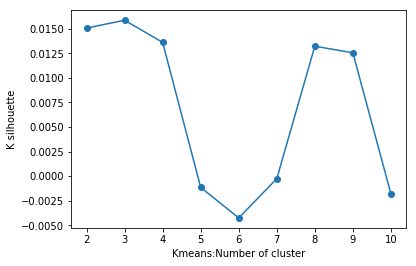

Time passed: 0hour:10min:52sec


In [8]:
tic()
svd = TruncatedSVD(n_components=2000, random_state = 0)
X_2d = svd.fit_transform(X_text)

sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_2d)
    preds=kmeans.predict(X_2d)
    #print(data["clusters"])
    sse[k] = silhouette_score(X_2d, preds, metric='euclidean') # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'-o')
plt.xlabel("Kmeans:Number of cluster")
plt.ylabel("K silhouette")
plt.show()
tac()

In [9]:
tic()
stop_words = set(stopwords.words("english"))

# components for features reduction
n_components = 2000

# number of clusters we want
n_clusters = 3

# transform matrix of plots into lists to pass to a TfidfVectorizer

tfidf=TfidfVectorizer(stop_words=stop_words)

X_text=tfidf.fit_transform(data_df['clean_body'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

tac()

   Cluster         0         1         2         3         4         5  \
0        0  0.088042 -0.030903  0.008374 -0.010490  0.025799  0.024432   
1        0  0.039925 -0.019535 -0.024395 -0.012778 -0.002277  0.036288   
2        0  0.015513  0.001226 -0.013557  0.004614  0.007603 -0.003113   
3        0  0.053256 -0.004634 -0.028544  0.004279  0.011490  0.013004   
4        0  0.129687  0.007262  0.000661 -0.119243 -0.074935  0.030334   

          6         7         8    ...         1990      1991      1992  \
0 -0.024764 -0.007621 -0.018786    ...    -0.016161  0.010634  0.002911   
1 -0.001015 -0.040728  0.014746    ...    -0.002416  0.005583 -0.014442   
2  0.002199 -0.007100  0.001015    ...     0.003163  0.005429 -0.015177   
3 -0.002498 -0.030173  0.005310    ...    -0.009769  0.003535  0.010474   
4 -0.081174  0.084358  0.004890    ...    -0.015667  0.002363 -0.005929   

       1993      1994      1995      1996      1997      1998      1999  
0 -0.003980  0.005764 -0.00028

Time passed: 0hour:0min:2sec


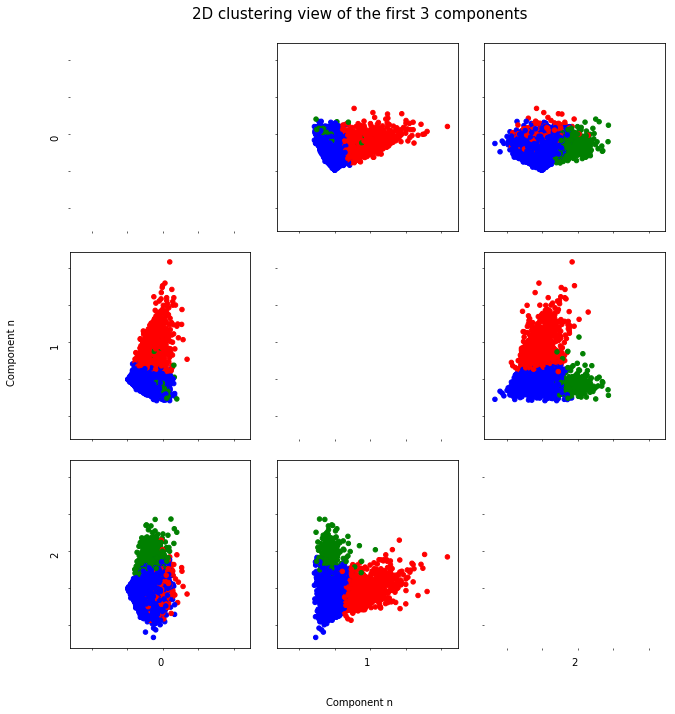

In [12]:
tic()
# make a column for color by clusters
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g'})

# variable for first n dimensions we want to plot
n = 3

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(10,10))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 10)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 15)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 10)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 10)
tac()

In [13]:
tic()
# Logistic Regression approach

data_df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = data_df['clean_body']
    y = data_df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = stop_words)
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d
tac()

Time passed: 0hour:0min:0sec


Time passed: 0hour:0min:4sec


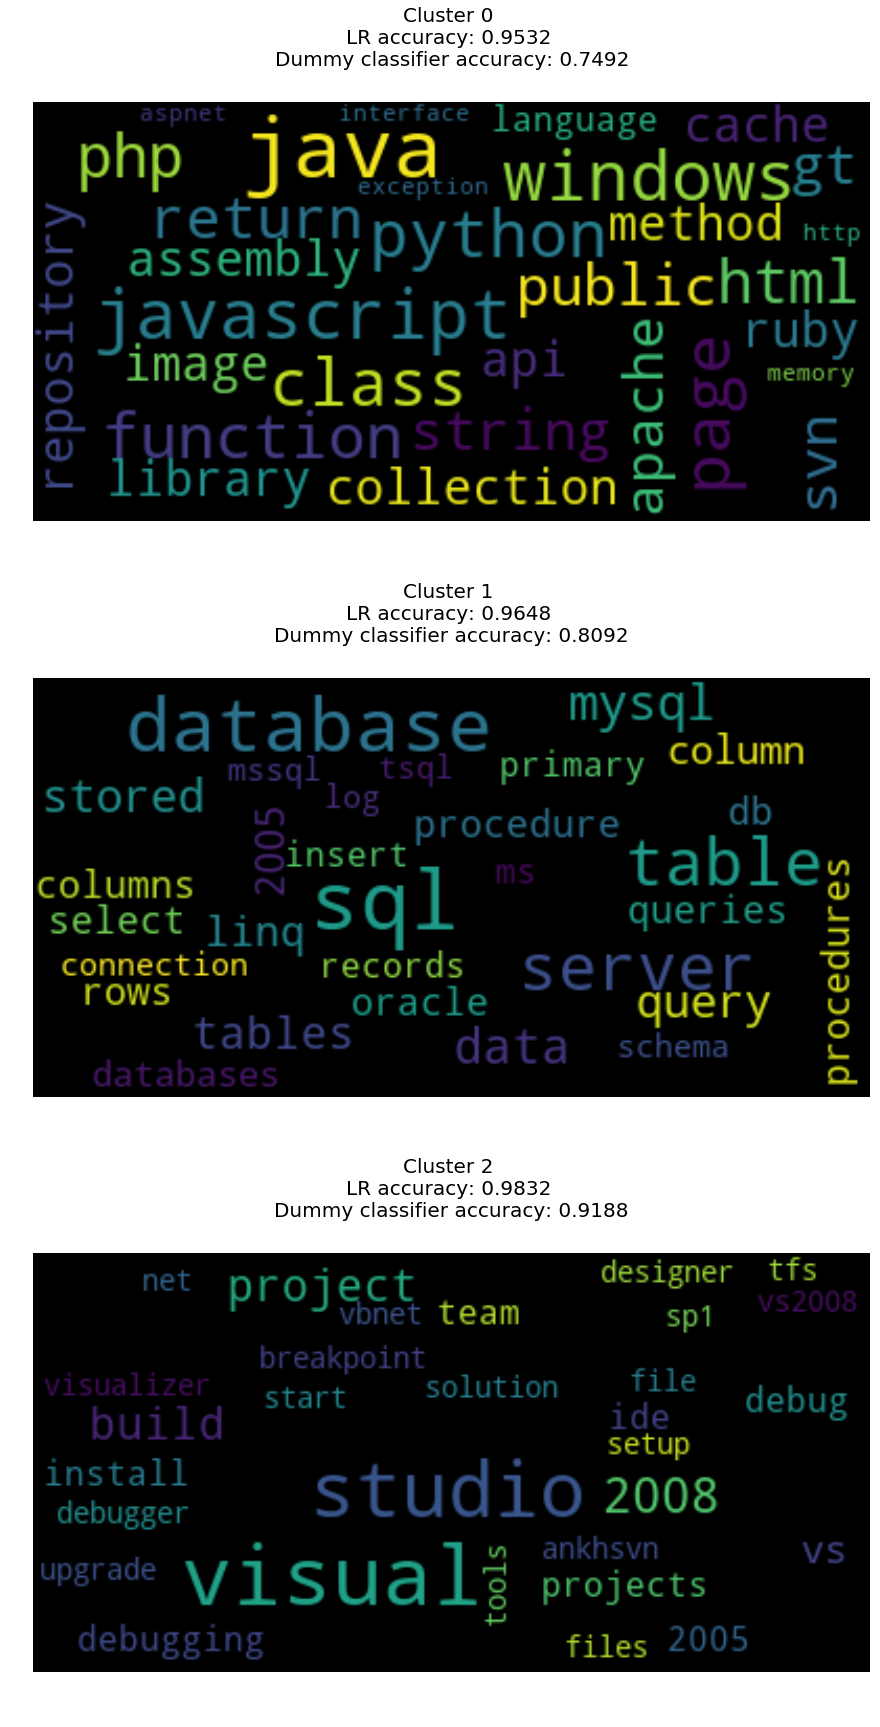

In [16]:
tic()
# visualized it by word clouds
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False).fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")
tac()

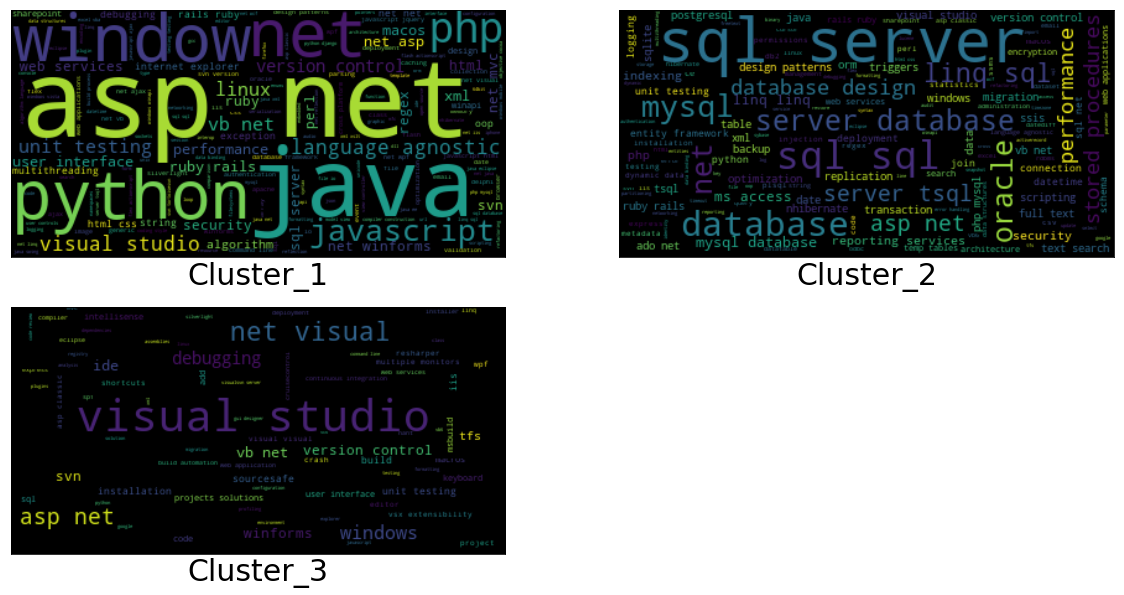

Time passed: 0hour:0min:2sec


In [18]:
tic()
tag_ff=[]
plt.figure(figsize=(20,10))
for i in range(0,3):
    df_tag=data_df[data_df['Cluster']==i]
    text= " ".join(tag_l for tag_l in df_tag.Tags_)
    wordcloud = WordCloud().generate(text)
    tag_ff.append(i)
    i=len(tag_ff)
    plt.subplot(2, 2,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Cluster_'+str(i),fontsize=30)
plt.show()
tac()

In [66]:
data_df.columns

Index(['Unnamed: 0', 'Id', 'CreationDate', 'Score', 'Body', 'Title', 'Tags',
       'Body_whtml', 'Tags_', 'Body_word_count', 'Title_word_count',
       'Tags_word_count', 'Title_body', 'Tags_plus', 'clean_word',
       'Tags_final', '.net', 'actionscript-3', 'ajax', 'algorithm', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa',
       'cocoa-touch', 'css', 'database', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'excel', 'flash', 'flex',
       'html', 'iis', 'internet-explorer', 'iphone', 'java', 'javascript',
       'jquery', 'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'versi

<span id="train"></span>
## 3.2. Model training

In [67]:
X=data_df[['clean_body']].as_matrix()
y=data_df['Cluster']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]

In [68]:
tic()
pipeline_us1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf',LogisticRegression(solver='sag')),
])
parameters_us1 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

grid_search_tune_us1 = GridSearchCV(pipeline_us1, parameters_us1, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us1.fit(train_x, y_train)
print (grid_search_tune_us1.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us1 = grid_search_tune_us1.best_estimator_
predictions_us1 = best_clf_us1.predict(test_x)

print (classification_report(y_test, predictions_us1))

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.2min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"you'd", 'who', 'some', 'wouldn', "shan't", 'having', 'that', 'too', 'about', 'theirs', 'up', 'how', "you've", 't', 'why', 'off', 'against', 'you', 'isn', "wasn't", 'aren', 'haven', 'where', 'for', 'should', 'between', 'each', 've', 'at', 'just', "wouldn't", 'these', 'it', 'itself', 'doe..., "hadn't", 'what', 'himself', 'only', 'her', "hasn't", 'ours', 'most', 'doing', "won't", 'm', 'to'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
        

In [69]:
pipeline_us2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LinearSVC()),
])

parameters_us2 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

grid_search_tune_us2 = GridSearchCV(pipeline_us2, parameters_us2, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us2.fit(train_x, y_train)
print (grid_search_tune_us2.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us2 = grid_search_tune_us2.best_estimator_
predictions_us2 = best_clf_us2.predict(test_x)

print (classification_report(y_test, predictions_us2))

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"you'd", 'who', 'some', 'wouldn', "shan't", 'having', 'that', 'too', 'about', 'theirs', 'up', 'how', "you've", 't', 'why', 'off', 'against', 'you', 'isn', "wasn't", 'aren', 'haven', 'where', 'for', 'should', 'between', 'each', 've', 'at', 'just', "wouldn't", 'these', 'it', 'itself', 'doe..., "hadn't", 'what', 'himself', 'only', 'her', "hasn't", 'ours', 'most', 'doing', "won't", 'm', 'to'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
 

In [70]:
tic()
pipeline_us3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])
parameters_us3 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'clf__alpha': (1e-2, 1e-3)
}
grid_search_tune_us3 = GridSearchCV(pipeline_us3, parameters_us3, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us3.fit(train_x, y_train)
print (grid_search_tune_us3.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us3 = grid_search_tune_us3.best_estimator_
predictions_us3 = best_clf_us3.predict(test_x)

print (classification_report(y_test, predictions_us3))
tac()

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   47.6s finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"you'd", 'who', 'some', 'wouldn', "shan't", 'having', 'that', 'too', 'about', 'theirs', 'up', 'how', "you've", 't', 'why', 'off', 'against', 'you', 'isn', "wasn't", 'aren', 'haven', 'where', 'for', 'should', 'between', 'each', 've', 'at', 'just', "wouldn't", 'these', 'it', 'itself', 'doe..., "hadn't", 'what', 'himself', 'only', 'her', "hasn't", 'ours', 'most', 'doing', "won't", 'm', 'to'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))]
Applying best classifier on test data:
             precision    recall  f

<span id="tags_u"></span>
## 3.3. Predict tags

In [71]:
import pickle
with open('logisticUS.pkl', 'wb') as fid:
    pickle.dump(grid_search_tune_us1.best_estimator_, fid,2)

In [19]:
def dote(a):
    a=a.group(0)
    a=re.sub("\.", "dote", a)
    return a

In [20]:
def clean(text):
    text=re.sub(r"http\S+", "", text)
    text = re.sub("#", "hash", text)
    text = re.sub("-", "menos", text)
    text = re.sub(r"\.[a-zA-Z0-9]+",dote, text)
    text=re.sub(re.escape('++'), 'plus', text)
    text=re.sub(r'[^\w\s]','',text)
    words = text.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = " ".join(w for w in words if not w in stops)
    return(meaningful_words)

In [21]:
def tag(text):
    text = re.sub("#", "hash", text)
    text = re.sub("-", "menos", text)
    text = re.sub(r"\.[a-zA-Z0-9]+",dote, text)
    text=re.sub(re.escape('++'), 'plus', text) 
    tags = text.lower().split()                                             
    meaningful_tag = " ".join(w for w in tags)
    return(meaningful_tag)

In [22]:
data_df['clean_words_']=data_df['Title_body'].apply(lambda x:clean(str(x)))

In [23]:
data_df['new_tags']=data_df['Tags_'].apply(lambda x:tag(str(x)))

In [36]:
def right(text):
    text=text.replace("hash", "#")
    text=text.replace("menos", "-")
    text=text.replace("plus", "++")
    text=text.replace("dote", ".") 
    text = [w for w in text.split()]
    return(text)

In [37]:
tic()
# LDA

no_top_tags = 100
def display_topics(model, feature_names, no_top_tags):
    for topic_idx, topic in enumerate(model.components_):
        Tags=" ".join([feature_names[i] for i in topic.argsort()[:-no_top_tags - 1:-1]])
    return Tags
        
for cluster in range(0,3):

    c = CountVectorizer()
    X_text_c = c.fit_transform(data_df[data_df['Cluster']==cluster]['new_tags'])

    lda = LatentDirichletAllocation(learning_method = 'online', n_components=1, random_state=0).fit(X_text_c)
    X_text_c_feature_names = c.get_feature_names()
    print("*"*40)
    print("Top Tags for cluster_"+str(cluster),':')
    print(right(display_topics(lda, X_text_c_feature_names, no_top_tags)))
    print()
tac()

****************************************
Top Tags for cluster_0 :
['c#', '.net', 'java', 'asp.net', 'c++', 'javascript', 'python', 'php', 'windows', 'html', 'xml', 'ruby', 'css', 'linux', 'svn', 'winforms', 'language-agnostic', 'unit-testing', 'vb.net', 'user-interface', 'macos', 'performance', 'algorithm', 'sql', 'ruby-on-rails', 'version-control', 'web-services', 'database', 'oop', 'multithreading', 'wpf', 'security', 'visual-studio', 'regex', 'flex', 'asp.net-mvc', 'perl', 'winapi', 'ajax', 'sharepoint', 'flash', 'debugging', 'jquery', 'eclipse', 'string', 'sql-server', 'apache', 'exception', 'oracle', 'design', 'iis', 'testing', 'actionscript-3', 'mysql', 'design-patterns', 'delphi', 'wcf', 'arrays', '.net-3.5', 'excel', 'generics', 'browser', 'internet-explorer', 'silverlight', 'linq', 'memory', 'parsing', 'validation', 'reflection', '.net-2.0', 'visual-studio-2008', 'deployment', 'optimization', 'networking', 'http', 'web-applications', 'objective-c', 'unix', 'firefox', 'image', 

In [173]:
def predict(text):
    text=text.lower()
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    text_=[clean_p(text)]
    predict=best_clf_us1.predict(text_)[0]
    c = CountVectorizer()
    X_text_c = c.fit_transform(data_df[data_df['Cluster']==predict]['new_tags'])
    lda = LatentDirichletAllocation(learning_method = 'online', n_components=1, random_state=0).fit(X_text_c)
    X_text_c_feature_names = c.get_feature_names()
    predict_tag="".join('<'+x+'>' for x in right(display_topics(lda, X_text_c_feature_names, 1000)) if x in text.split())
    
    if predict_tag=='':
        predict_tag="".join('<'+x+'>' for x in right(display_topics(lda, X_text_c_feature_names, 1000))[0:5])
                          
    return predict_tag

In [174]:
predict(data_df['Title_body'][100])

'<php><variables>'